In [1]:
import random
import matplotlib

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm import tqdm
from collections import Counter
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
from IPython.display import clear_output

In [2]:
def print_stats(day):
    return "day:", day , "population:", len(population), "infected:", get_status(), "quarrentined:", len(quarrentined), "probability:", get_status()/len(population)

In [3]:
def gen_rand_coordinates(n):
    x = np.random.randint(low=0, high=2*n, size=n)
    y = np.random.randint(low=0, high=2*n, size=n)
    
    coordinates = [(i, j) for i, j in zip(x, y)]
    
    return list(set(coordinates)), list(range(len(set(coordinates))))

In [4]:
def random_walk(current_position, person):
    path = []
    edges = []
    path.append(deepcopy(current_position))
    
    percentage = int(len(quarrentined)/2000)
    
    if person['age']>18 and person['age']<50:
        m = 50
        m_ = int(m/10)
        m = m - (m_*percentage)
        n = np.random.randint(0, m)
        
    else:        
        m = 20
        m_ = int(m/10)
        m = m - (m_*percentage)
        n = np.random.randint(0, m)
        
    for i in range(n):
        person_neighbours = neighbours[current_position]
        if len(person_neighbours) > 0:
            next_position = np.random.choice(person_neighbours)
            path.append(next_position)
            edges.append((current_position, next_position))
            current_position = deepcopy(next_position)
    return path, edges

In [5]:
def random_sample(data, n):
    idx = np.random.randint(low=0, high=len(data), size=n)
    return [data[i] for i in idx], idx

In [6]:
def get_status(effected=True):
    return Counter([p['effected'] for p in population.values()])[effected]

In [7]:
def get_p_at(effected=True):
    return [p['at'] for p in population.values() if p['effected']]

In [8]:
def effect_person(person):
    person['effected'] = True
    person['incubation_period'] = np.random.randint(low=5, high=10)

In [9]:
def plot_plot(rw_normal_edges=None, rw_effected_edges=None, clear=False, iter_=0):
    clear_output(wait=clear)
    
    pop = [p['at'] for i, p in population.items()]
    eff = get_p_at()

    plt.figure(0, figsize=(25, 25))
    
    nx.draw_networkx_nodes(G, pos,
                           nodelist=pop,
                           node_color='blue', node_size=5)

    nx.draw_networkx_nodes(G, pos,
                           nodelist=eff,
                           node_color='r', node_size=50)

    nx.draw_networkx_edges(G, pos,
                           edgelist=edges,
                           width=0.3,alpha=0.3,edge_color='b')

    if rw_normal_edges is not None:
        nx.draw_networkx_edges(G,pos,
                               edgelist=rw_normal_edges,
                               width=0.5,alpha=0.3,edge_color='y')

        nx.draw_networkx_edges(G,pos,
                               edgelist=rw_effected_edges,
                               width=2,alpha=0.3,edge_color='red')

    nx.draw_networkx(G, pos, node_size=1, with_labels=False)
    s = "Day: "+str(iter_)+" | Population: " + str(len(population)) + " | Infected: " + str(get_status()) + " | Quarrentined: " + str(len(quarrentined)) + " | Infection Probability: " + str(round(get_status()/len(population), 2))
    plt.title(s, fontsize=40)
    plt.savefig("image"+str(iter_)+".png", format="PNG")
    plt.show()

In [10]:
n_days = 100

In [11]:
n_nodes = 5000
connectivity = 5
n_population = n_nodes * 2
n_effected_people = 2 #int(n_population/100)

contamination_confidence = 100

In [12]:
coordinates, coordinates_idx = gen_rand_coordinates(n_nodes)

In [13]:
_, p_coord = random_sample(coordinates, n_population)

In [14]:
p_ages = np.random.randint(low=2, high=80, size=n_population)

In [15]:
population = {i:{'at': j, 'age': k, 'effected': False, 'incubation_period':-1} for i, j, k in zip(range(n_population), p_coord, p_ages)}

In [16]:
effected, _ = random_sample(list(population.keys()), n_effected_people)
for i in effected:
    effect_person(population[i])
del effected

In [17]:
edges = []
c = np.array(coordinates)
while len(set(edges)) < n_nodes * connectivity:
    print(len(set(edges)))
    t, t_idx = random_sample(c, 1000)
    u, u_idx = random_sample(c, 1000)
    dist = euclidean_distances(t, u)
    for idx, i in enumerate(dist):
        a = np.argsort(i)[:2]
        edges += [(t_idx[idx], u_idx[j]) for j in a if i[j]<(n_nodes/10) and i[j] != 0]
edges = set(edges)

0
1538
3039
4512
5955
7393
8826
10179
11503
12793
14101
15374
16600
17799
18979
20188
21332
22458
23570
24707


In [18]:
neighbours = {i:[] for i in coordinates_idx}
for i, j in edges:
    neighbours[i] += [j]
    neighbours[j] += [i]

In [19]:
len(coordinates), len(population), len(edges), get_status()

(5000, 10000, 25762, 2)

In [20]:
G_dash = nx.Graph()
for p in tqdm(range(len(coordinates))):
    G_dash.add_node(p, pos=[coordinates[p][0], coordinates[p][1]])
pos = nx.get_node_attributes(G_dash, 'pos')
G = deepcopy(G_dash)

100%|██████████| 5000/5000 [00:00<00:00, 207813.70it/s]


In [21]:
quarrentined = {}

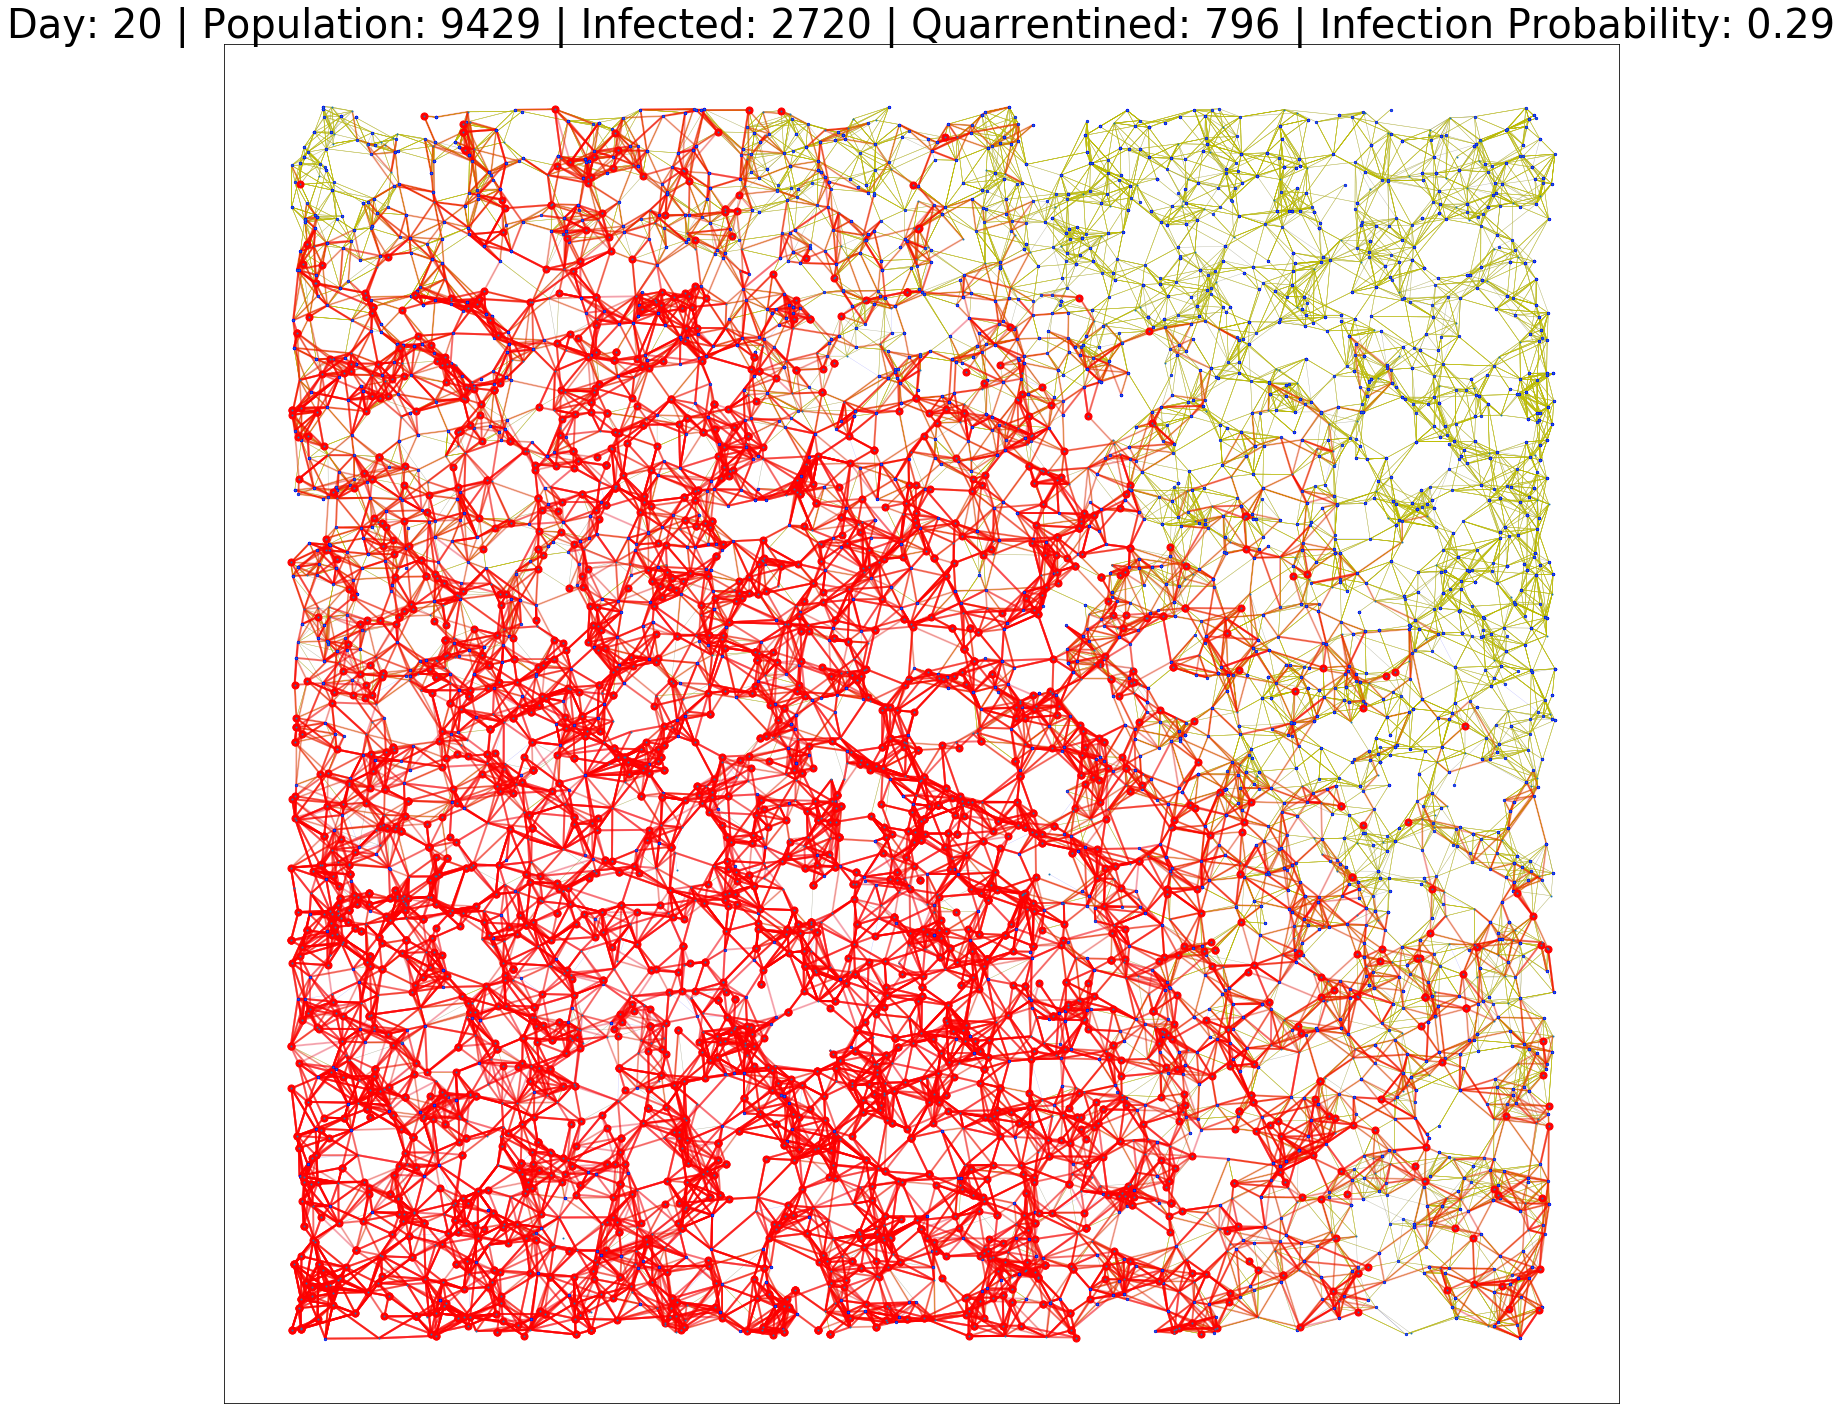

In [ ]:
for day in range(n_days):

    print_stats(day)
    
    del_pids = []
    
    rw_normal = {}
    rw_effected = {}

    rw_normal_edges = []
    rw_effected_edges = []

    for pid, person in population.items():
        current_position = person['at']
        _, rw_edges = random_walk(current_position, person)

        if person['effected']:
            rw_effected[pid] = rw_edges
            rw_effected_edges += rw_edges
            
            person['incubation_period'] -= 1
            
            if person['incubation_period'] == 0:
                quarrentined[pid] = person
                del_pids.append(pid)
        else:
            rw_normal[pid] = rw_edges
            rw_normal_edges += rw_edges

    contaminated_paths = Counter(rw_effected_edges)
    
    plot_plot(iter_=day, rw_effected_edges = rw_effected_edges, rw_normal_edges=rw_normal_edges)

    for pid, j in rw_normal.items():
        similar_paths = list(set(j).intersection(set(rw_effected_edges)))
        
        contamination_probability = sum([contaminated_paths[s] for s in similar_paths])

        denominator = contamination_confidence + contamination_probability
        if np.random.choice([0, 1], p=[contamination_confidence/denominator, contamination_probability/denominator]):
            effect_person(population[pid])
            
    for pid in del_pids:
        del population[pid]